In [ ]:
# AnoGAN
#Kaggle에서 필요한 데이터셋을 다운받고 압축 해제를 진행합니다.

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d preetviradiya/covid19-radiography-dataset

!unzip covid19-radiography-dataset.zip

In [1]:
import os
import numpy as np
from keras.preprocessing import image

training_img_dir = '/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal'
anormaly_img_dir = '/content/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID'

def img_preprocessing(file_directory):

  lst = []
  
  filenames = os.listdir(file_directory)
  
  for filename in filenames:
    img = image.load_img(os.path.join(file_directory, filename), 
                         target_size=(128, 128),
                         color_mode='grayscale') # color_mode = 'grayscale' or 'rgb'
    img = image.img_to_array(img).astype('float32')
    img = img / 255.0
    lst.append(img)
  
  return np.array(lst)

In [2]:
training_data = img_preprocessing(training_img_dir)
anormaly_data = img_preprocessing(anormaly_img_dir)

training_data.shape, anormaly_data.shape

((10192, 128, 128, 1), (3616, 128, 128, 1))

In [6]:
Model_d, Model_g = train(256, training_data)

#### discriminator ######
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 128)       0         
                                                                 
 flatten_1 (Flatten)        

100%|██████████| 300/300 [6:16:24<00:00, 75.28s/it]


In [50]:
test = training_data.reshape(-1, 128, 128, 1)
test_img = test[10]

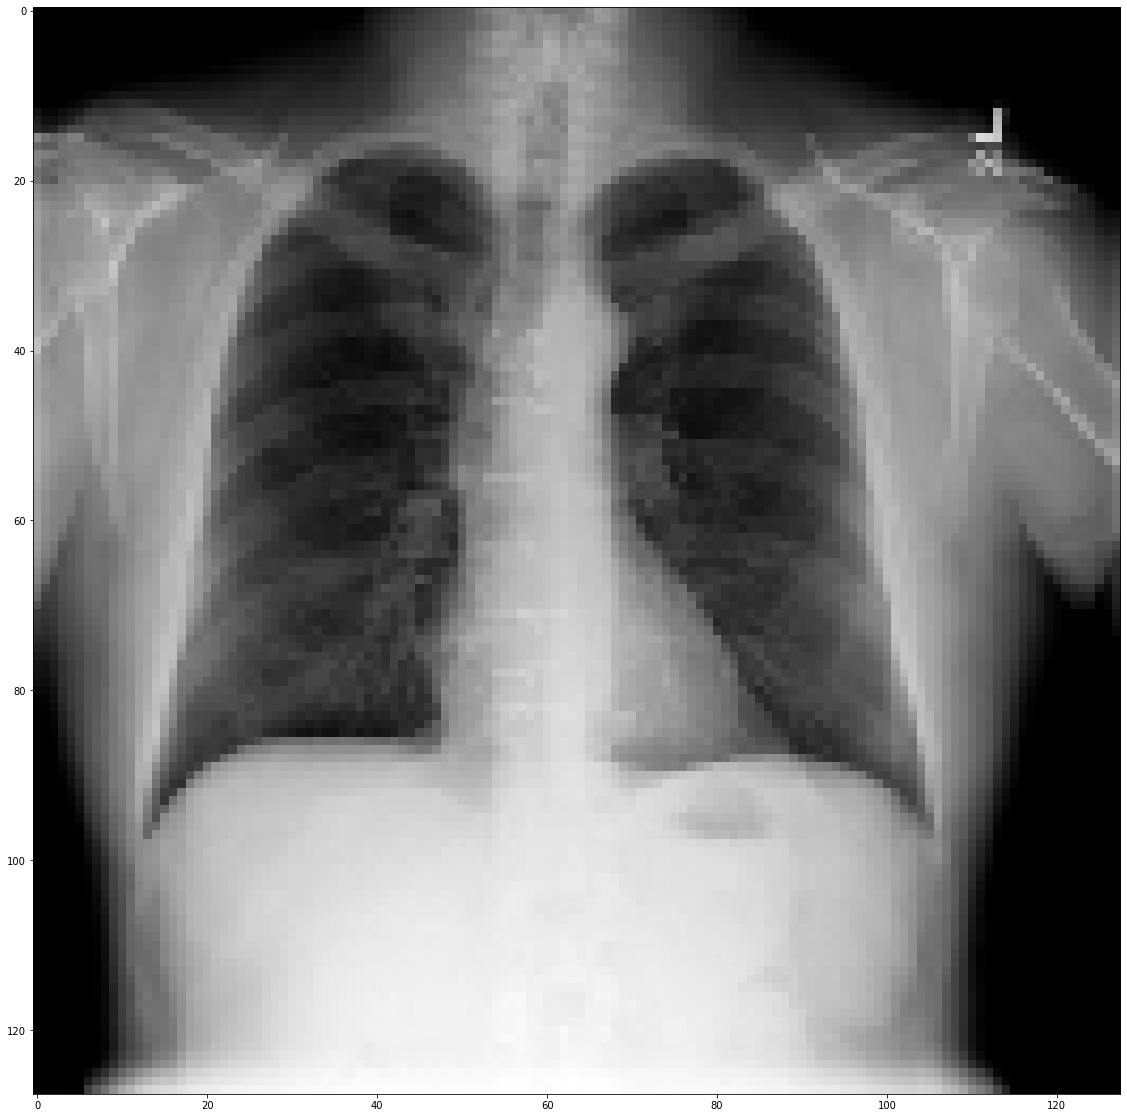

anomaly score : 12482.142578125


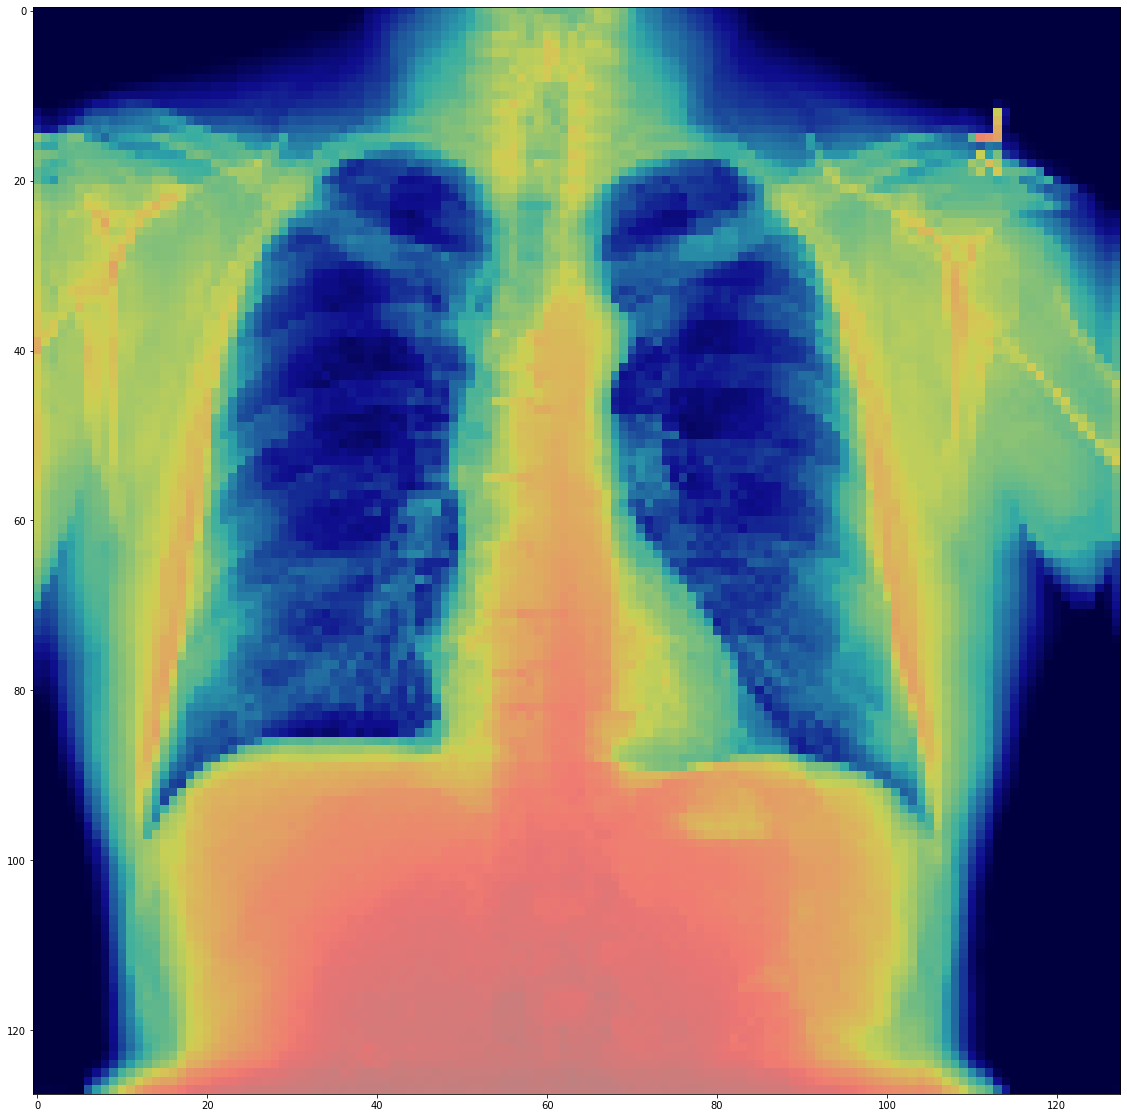

In [52]:
model = anomaly_detector()
ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 128, 128, 1))

plt.figure(figsize=(20, 20))
plt.imshow(test_img.reshape(128,128), cmap=plt.cm.gray)
plt.show()
print("anomaly score : " + str(ano_score))
plt.figure(figsize=(20, 20))
plt.imshow(test_img.reshape(128,128), cmap=plt.cm.gray)
residual = test_img.reshape(128,128) - similar_img.reshape(128,128)
plt.imshow(residual, cmap='jet', alpha=.5)
plt.show()

In [7]:
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, Dense, Dropout, UpSampling2D, Conv2D, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras import backend as K
from keras import initializers
import tensorflow as tf
import numpy as np
from tqdm import tqdm

def generator_model():
    generator = Sequential()
    generator.add(Dense(128*32*32, input_dim=100, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((32, 32, 128)))
    generator.add(UpSampling2D(size=(2, 2)))
    generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
    generator.add(LeakyReLU(0.2))
    generator.add(UpSampling2D(size=(2, 2)))
    generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer='adam')
    return generator

def discriminator_model():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(128, 128, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer='adam')
    return discriminator

def generator_containing_discriminator(g, d):
    d.trainable = False
    ganInput = Input(shape=(100,))
    x = g(ganInput)
    ganOutput = d(x)
    gan = Model(inputs=ganInput, outputs=ganOutput)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

def train(BATCH_SIZE, X_train):
    d = discriminator_model()
    print("#### discriminator ######")
    d.summary()
    g = generator_model()
    print("#### generator ######")
    g.summary()
    d_on_g = generator_containing_discriminator(g, d)
    d.trainable = True
    for epoch in tqdm(range(300)):
        for index in range(int(X_train.shape[0]/BATCH_SIZE)):
            noise = np.random.uniform(0, 1, size=(BATCH_SIZE, 100))
            image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
            generated_images = g.predict(noise, verbose=0)
            X = np.concatenate((image_batch, generated_images))
            y = np.array([1] * BATCH_SIZE + [0] * BATCH_SIZE)
            d_loss = d.train_on_batch(X, y)
            noise = np.random.uniform(0, 1, (BATCH_SIZE, 100))
            d.trainable = False
            g_loss = d_on_g.train_on_batch(noise, np.array([1] * BATCH_SIZE))
            d.trainable = True
        g.save_weights('assets/generator', True)
        d.save_weights('assets/discriminator', True)
    return d, g


def generate(BATCH_SIZE):
    g = generator_model()
    g.load_weights('assets/generator')
    noise = np.random.uniform(0, 1, (BATCH_SIZE, 100))
    generated_images = g.predict(noise)
    return generated_images

def sum_of_residual(y_true, y_pred):
    return tf.reduce_sum(abs(y_true - y_pred))

def feature_extractor():
    d = discriminator_model()
    d.load_weights('assets/discriminator') 
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-5].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='adam')
    return intermidiate_model

def anomaly_detector():
    g = generator_model()
    g.load_weights('assets/generator')
    g.trainable = False
    intermidiate_model = feature_extractor()
    intermidiate_model.trainable = False
    
    aInput = Input(shape=(100,))
    gInput = Dense((100))(aInput)
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.9, 0.1], optimizer='adam')
    return model

def compute_anomaly_score(model, x):    
    z = np.random.uniform(0, 1, size=(1, 100))
    intermidiate_model = feature_extractor()
    d_x = intermidiate_model.predict(x)
    loss = model.fit(z, [x, d_x], epochs=500, verbose=0)
    similar_data, _ = model.predict(z)
    return loss.history['loss'][-1], similar_data